# **Heart disease classification**

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, f1_score, jaccard_score, log_loss,
classification_report, confusion_matrix, roc_curve, auc)
from imblearn.over_sampling import SMOTE
import joblib

## 1) Load Dataset

In [37]:
df = pd.read_csv("16325569497737558.csv")
print(df.head())

   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1  


## 2) Data Exploration

In [58]:
print("Missing values:\n", df.isnull().sum())   # Check for missing values
print("\nData Summary:\n", df.describe())       # Basic statistics

Missing values:
 age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

Data Summary:
               age         sex          cp      trtbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg    thalach

## 3) Separate features (X) and target (y)

In [39]:
X = df.drop("output", axis=1)
y = df["output"]

## 4) Split the dataset into training and testing sets

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y)

## 5) Feature Scaling

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Keep feature names after scaling

In [42]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

## 6) Handle class imbalance using SMOTE

In [46]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

## 7) Initialize and train models with hyperparameter tuning

In [44]:
models = {}

7.1) KNN with GridSearchCV

In [47]:
knn = KNeighborsClassifier()
knn_params = {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}
knn_gs = GridSearchCV(knn, knn_params, cv=5, scoring="f1")
knn_gs.fit(X_train_res, y_train_res)
models["KNN"] = knn_gs.best_estimator_


7.2) Decision Tree with GridSearchCV

In [48]:
dt = DecisionTreeClassifier(random_state=42)
dt_params = {"max_depth": [None, 3, 5, 7], "min_samples_split": [2, 5, 10]}
dt_gs = GridSearchCV(dt, dt_params, cv=5, scoring="f1")
dt_gs.fit(X_train, y_train)   # Decision tree works fine without scaling
models["Decision Tree"] = dt_gs.best_estimator_

7.3) Logistic Regression

In [49]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_res, y_train_res)
models["Logistic Regression"] = lr

7.4) Support Vector Machine with GridSearchCV

In [50]:
svm = SVC(probability=True, random_state=42)
svm_params = {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
svm_gs = GridSearchCV(svm, svm_params, cv=5, scoring="f1")
svm_gs.fit(X_train_res, y_train_res)
models["SVM"] = svm_gs.best_estimator_

## 8) Evaluate Models

In [60]:
results = {}
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    jaccard = jaccard_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    results[name] = {
        "Accuracy": accuracy,
        "F1-Score": f1,
        "Jaccard Index": jaccard,
        "Log Loss": logloss
    }
    
    print(f"\n{name} Evaluation:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


KNN Evaluation:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79        28
           1       0.81      0.88      0.84        33

    accuracy                           0.82        61
   macro avg       0.82      0.81      0.82        61
weighted avg       0.82      0.82      0.82        61

Confusion Matrix:
 [[21  7]
 [ 4 29]]

Decision Tree Evaluation:
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        28
           1       0.74      0.76      0.75        33

    accuracy                           0.72        61
   macro avg       0.72      0.72      0.72        61
weighted avg       0.72      0.72      0.72        61

Confusion Matrix:
 [[19  9]
 [ 8 25]]

Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.83      0.68      0.75        28
           1       0.76      0.88      0.82        33

    accuracy                 

## 9) Compare results in a DataFrame


In [61]:
results_df = pd.DataFrame(results).T
print("\nModel Comparison:\n", results_df)


Model Comparison:
                      Accuracy  F1-Score  Jaccard Index  Log Loss
KNN                  0.819672  0.840580       0.725000  2.093837
Decision Tree        0.721311  0.746269       0.595238  0.562329
Logistic Regression  0.786885  0.816901       0.690476  0.442700
SVM                  0.786885  0.821918       0.697674  0.416421


## 10) Visualization of model comparison

<Figure size 1000x600 with 0 Axes>

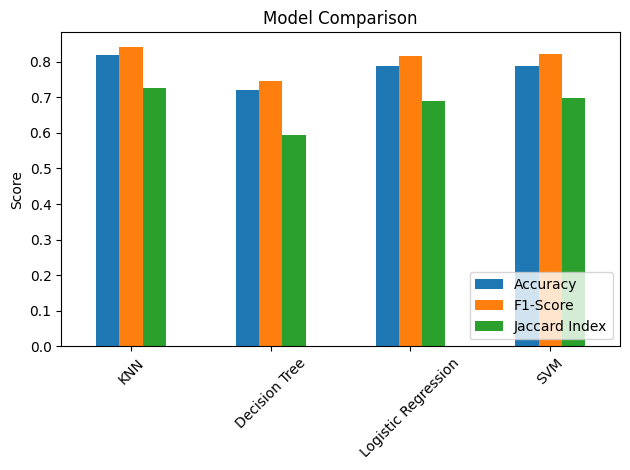

In [55]:
plt.figure(figsize=(10, 6))
results_df[['Accuracy', 'F1-Score', 'Jaccard Index']].plot(kind='bar')
plt.title("Model Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


## 11) Save the best model


In [56]:
best_model_name = results_df.sort_values("F1-Score", ascending=False).index[0]
best_model = models[best_model_name]
joblib.dump(best_model, "best_heart_model.joblib")

print(f"\nBest Model: {best_model_name} has been saved as 'best_heart_model.joblib'")



Best Model: KNN has been saved as 'best_heart_model.joblib'
